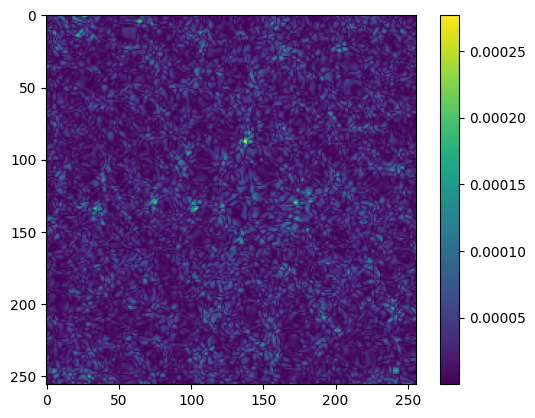

In [137]:
import torch 
import numpy as np
import unfoldNd
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

d = torch.tensor(np.load("ks2d_short.npy"))
maxval, minval = d.max(), d.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
d = normalize(d)

BC_0 = { "mode": "circular", "val_left": None, "val_right": None }
BC_1 = { "mode": "circular", "val_left": None, "val_right": None }
BC = [BC_0, BC_1]

def pad(d, axis, extent, mode="circular", val_left=None, val_right=None):
    permutation = list(range(len(d.shape)))
    permutation[axis] = len(d.shape)-1
    permutation[-1] = axis
    d = d.permute(*permutation)

    if mode == "circular":
        assert extent <= d.shape[-1]
        left, right = d[...,-extent:], d[...,:extent]
    elif mode == "dirichlet": 
        shape = list(d.shape[:-1]) + [extent]
        left, right = torch.ones(shape)*val_left, torch.ones(shape)*val_right
    else:
        raise Exception

    d = torch.cat((left, d, right), dim=-1)
    d = d.permute(*permutation)
    return d

class ConvELM2D(torch.nn.Module):
    def __init__(self, extent=2, hidden=100, bc=[{"mode":"circular"}, {"mode":"circular"}]):
        super().__init__()
        self.extent = extent
        self.ks = 2*self.extent + 1
        self.hidden = hidden
        self.bc = bc
        self.phi_conv = torch.nn.Sequential(torch.nn.Conv2d(1, self.hidden, self.ks), torch.nn.Softplus()).double()
        self.out_layer = torch.nn.Conv2d(self.hidden, 1, 1, bias=False).double()

    def phi(self, X):
        assert len(X.shape) == 4, f"input must have the form (batch, channels, im1, im2), but has shape {X.shape}"
        X = pad(X, 2, self.extent, **self.bc[0])
        X = pad(X, 3, self.extent, **self.bc[1])
        X = self.phi_conv(X)
        return X
    
    def forward(self, X):
        assert len(X.shape) in [3,4], f"input must have the form (batch, channels, im1, im2) OR (channels, im1, im2), but has shape {X.shape}"
        unbatched = len(X.shape)==3
        if unbatched: X = X.unsqueeze(0)
        phiX = self.phi(X)
        out = self.out_layer(phiX)
        if unbatched: out = out.squeeze(0)
        return out

    def train(self, X, Y):
        phiX = self.phi(X)
        phiX = phiX.permute(0,2,3,1) # shifts the channel axis to the last index
        phiX = phiX.view(-1, self.hidden) # conflates the first few axes, except for the channels
        Y = Y.view(-1, 1)
        A = torch.linalg.lstsq(phiX, Y).solution.transpose(0,1)
        A = A.view(1, self.hidden, 1, 1)
        self.out_layer.weight.data = A

model = ConvELM2D(2, 100)
noise_distr = torch.distributions.Normal(0, 1e-4)
X = d[0,None,None,...] 
X = X + noise_distr.sample(X.shape) 
Y = d[1,None,None,...]

model.train(X, Y)

# prediction
err = ( model(d[0,None,...])-d[1,None,...] ).abs().squeeze(0)
plt.colorbar(plt.imshow(err.cpu().numpy()))
plt.show()

In [138]:

# enjoy a nice animation
import itertools
%matplotlib qt
torch.set_grad_enabled(False)

# Dirichlet boundary conditions
BC_0 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # vertical axis
BC_1 = { "mode": "dirichlet", "val_left": 0, "val_right": 0 } # horizontal axis
model.bc = [BC_0, BC_1]

T = d[0,None,...]
z = torch.sin(torch.linspace(0,torch.pi,d.shape[1])).expand_as(T)
z = z * torch.sin(torch.linspace(0,torch.pi,d.shape[1])).expand_as(T).transpose(1,2)
T = T * z

im = plt.matshow(T[0,...].cpu().numpy(), vmin=0, vmax=1)
model_fast= model.to(torch.float32).to("cuda")
T_fast = T.to(torch.float32).to("cuda")
# energy = T_fast.mean()
for j in itertools.count():
    T_fast = model_fast(T_fast)
    # T_fast = energy + T_fast - T_fast.mean()
    if j % 10 == 0:
        im.set_data(T_fast[0,...].cpu())
        plt.pause(0.000001)
        plt.draw()

KeyboardInterrupt: 